In [278]:
# Setup

!pip install --upgrade torch
!pip install --upgrade pyro-ppl
!pip install --upgrade scipy
!pip install --upgrade matplotlib
!pip install --upgrade scikit-optimize

     |████████████████████████████████| 80.5 MB 75.5 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 38.2 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=7aa5ea8c055ebba9c45f8d5b6622f211b1968e36747edbcb96f5bd44acaa0388
  Stored in directory: /Users/alexkotlar/Library/Caches/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
Requirement already up-to-date: pyro-ppl in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (1.3.1)
Requirement already up-to-date: scipy in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (1.4.1)
Requirement already up-to-date: matplotlib in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (3.2.1)
Requirement already up-to-date: scikit-optimize in /Users/alexkotlar/miniconda3/li

In [279]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
# from torch.distributions import Binomial, Gamma, Uniform
from pyro.distributions import Binomial, Bernoulli, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma, Multinomial

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot

from collections import namedtuple
import time
seed = 0

In [15]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

Done
Scalar version took: 0.11273598670959473
Done
Tensor version took: 3.4068148136138916
Done
Tensor convert array version took: 0.14068198204040527


In [303]:
#### Likelihood functions
# These assume univariate currently

# TODO:
# 1) Explore constraining alphas using prevalence estimate, namely E(P(D)) = alpha0 / (alpha0 + alpha1 + alpha2 + alphaBoth) (as long as all case counts are mutually exclusive)
# 2) Can DM approximate NB + Multinomial? If so do we need mixture at all? But if we don't have that how do we model % disease-afffecting genes in each hypothesis(maybe proportion of alphas?)
# rr: relative risk
# P(V|D) = P(D|V)*P(V) / P(D)
# rr * P(D|!V) = P(D|V)
# P(V|D) = rr * P(D|!V) * P(V) / P(D)
# P(D) = (P(D|V)P(V) + P(D|!V)P(!V))
# P(D) = P(D|V) + P(D|!V)(1-P(V))
# P(V|D) = ( rrP(D|!V)) ) * P(V) ) / ( (P(D|V)P(V) + P(D|!V)(1-P(V))) )
# let a = ( rrP(D|!V)) ) * P(V) )
# P(V|D) = a / P(D|!V) / ( P(D|V)P(V) + P(D|!V) - P(D|!V)P(V) ) / P(D|!V)
# = ( rr*P(V) ) / ( rr*P(V) + 1 - P(V) )
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence, tensor of mConditions x 1
# pVgivenD: tensor of mConditions x 1
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - (pD*pVgivenD).sum()) / (1 - pD.sum())
    if(p < 0):
        raise ValueError(f"pVgivenNotD: invalid params: pD: {pD}, pV: {pV}, pVgivenD: {pVgivenD} yield: p = {p}")
    return p

# def pVgivenNotD(pD, pV, pVgivenD):
#     p = (pV - (pD*pVgivenD)) / (1 - pD)
#     assert(p >= 0)
#     return p

def pDgivenV(pD, pVgivenD, pV):
    return pVgivenD * pD / pV

# works like shit
def llUnivariateSingleGeneJensen(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return pi0 * Binomial(total_count=n, probs=pD).log_prob(xCase) + pi1*Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)

def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))

# alphas shape: [2] #corresponding to cases and controls
def llUnivariateSingleGeneBetaBinomial(xCtrl, xCase, pD, alphas, pi0, pi1):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    h0 = pi0 * torch.exp( Binomial(total_count=n, probs=pD).log_prob(xCase) )
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alphas[1], concentration0=alphas[0]).log_prob(xCase) )
    return torch.logalpha3( h0 + h1 )

# TODO: support pooled and non-pooled controls
# TODO: think about whether we need overlapping cases (both disease1 + disease2) or whether that can be inferred
# altCounts.shape = [1 control + nConditions cases, 1]
# alphas shape: [nConditions + 2] #1 ctrl + nCondition cases; for now the last condition in nCondition cases is for individuals who has all of the previous nConditions
# in a more multivariate setting we will need more information, aka mapping to which combinations of conditions these people have
# xCases: we have nConditions cases
# pDs shape: [nConditions]
# TODO: make this more effificent by taking alphas tensor of shape (1 + nConditions)
def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
    # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
    n = altCounts.sum()
    alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
    print("n is ", n)
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
    case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
    h0 = pi0 * case1nullLikelihood * case2nullLikelihood
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
    h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
    h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
    print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
    return torch.log( h0 + h1 + h2 + h3 )

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
def likelihoodUnivariate(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        pDgivenV = params[0]
        pi1 = params[1]
        pi0 = 1 - pi1
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            print("returning inf")
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # 
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            pd = pDs[0]
            
            if ctrlAltCount == 0 and caseAltCount == 0:
                print("skipping", geneIdx)
                continue

            # this is insanely slow
            ll = llUnivariateSingleGene(ctrlAltCount, caseAltCount, pd, pi0, pi1, pDgivenV)

            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlAltCount}, caseCount: {caseAltCount}")
                penaltyCount -= 1
                continue
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        return -logLikelihood * (nGenes / penaltyCount)
    
    return likelihood

def likelihoodUnivariateFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, pDgivenV = params

        pi0 = 1.0 - pi1

        if(pDgivenV > 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            return float("inf")
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = Binomial(total_count=geneSums, probs=pDgivenV)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))
        
        return - torch.log(component0 + component1).sum()
    
    return likelihood

def likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, alpha1, alpha0 = params

        if alpha1 < 0 or alpha0 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1

        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

def getUnivariateAlpha0(alpha1, pD):
    return ((1-pD) / pD)*alpha1

# doesn't really work constraint looks wrong
def likelihoodUnivariateBetaBinomialConstrainedFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    pNotDRatio = (1 - pD)/pD
    def likelihood(params):
        pi1, alpha1 = params
        
        if alpha1 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1
        
        alpha0 = pNotDRatio*alpha1
        
        assert(alpha0 > 0)
        
        print("alpha0",alpha0)
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

# Bivariate likelihood function modeled on:
#def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
# # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
# n = altCounts.sum()
# alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
# case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
# case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
# h0 = pi0 * case1nullLikelihood * case2nullLikelihood
# h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
# h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
# h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
# print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
# return torch.log( h0 + h1 + h2 + h3 )
def likelihoodBivariateFast(altCountsByGene, pDs):
    globalCount = nSamples
    nGenes = altCountsByGene.shape[0]

    geneSums = altCountsByGene[:, :, :].sum([1,2])

    ctrlCounts = altCountsByGene[:, 0, 0]
    altCountsCases = altCountsByGene[:, :, 1]
    
    altCountsFlat = []
    for geneIdx in range(nGenes):
        altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1].flatten()])

    altCountsFlat = tensor(altCountsFlat)
    # nGenes x 4 
    xCtrl = altCountsFlat[:, 0]
    xCase1 = altCountsFlat[:, 1]
    xCase2 = altCountsFlat[:, 2]
    xCase12 = altCountsFlat[:, 3]
    # nGenes x 1
    n = xCtrl + xCase1 + xCase2 + xCase12
    print("altCountsFlat", altCountsFlat)
    print("n", n)
    print("xCase1, xCase2, xCase12", xCase1)
    print("xCase1, xCase2, xCase12", xCase2)
    print("xCase1, xCase2, xCase12", xCase12)
    
    pd1 = pDs[0]
    pd2 = pDs[1]
    pdBoth = pDs[2]

    case1Null = torch.exp(Binomial(total_count=n, probs=pd1).log_prob(xCase1))
    case2Null = torch.exp(Binomial(total_count=n, probs=pd2).log_prob(xCase2))
    caseBothNull = torch.exp(Binomial(total_count=n, probs=pdBoth).log_prob(xCase12))
    allNull = case1Null * case2Null * caseBothNull
    allNull2 = torch.exp(Multinomial(probs=tensor([1-pDs.sum(), pDs[0], pDs[1], pDs[2]])).log_prob(altCountsFlat))
    print("allNull2", allNull2)
    def likelihood1(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1) ) * case2Null * caseBothNull
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2) ) * case1Null * caseBothNull
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood1a(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood1b(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1 + xCase12) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2 + xCase12) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihoodConstrained(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull
        
        # idea 1
        # alpha1 and alpha0 determined
        # A gene has counts from gene1 samples 2 , from gene2 samples 1 geneBoth count
        # if i have some people that only have 1, that is evidence for gene1 liability, but says nothing for liability for 
        # the more shared risk there is, the more the count will be in the "both category", 
        # the fewer people will be only one or the other
        # so eventually all 
        # 
        h1 = pi1 * torch.exp( DirichletMultinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1 + xCase12) ) * case2Null
        
        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1 + xCase12) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2 + xCase12) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1) ) * case2Null * torch.exp( BetaBinomial(total_count=n, concentration1=alphaBoth, concentration0=alphasSum - alphaBoth).log_prob(xCase12) )
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2) ) * case1Null * torch.exp( BetaBinomial(total_count=n, concentration1=alphaBoth, concentration0=alphasSum - alphaBoth).log_prob(xCase12) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2a(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1 + alphaBoth, concentration0=alphasSum - alpha1).log_prob(xCase1) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2 + alphaBoth, concentration0=alphasSum - alpha2).log_prob(xCase2) ) * case1Null 
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    
    def likelihood2b(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2

        h1 = pi1 * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha0, alpha1])).log_prob(altCountsFlat) )
        h2 = pi2 * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha0, alpha2, alpha2])).log_prob(altCountsFlat) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alphaBoth, alphaBoth, alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2c(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2

        h1 = pi1 * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1+alphaBoth, alpha0, alpha1+alphaBoth])).log_prob(altCountsFlat) )
        h2 = pi2 * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha0, alpha2+alphaBoth, alpha2+alphaBoth])).log_prob(altCountsFlat) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1+alphaBoth, alpha2+alphaBoth, alpha1+alphaBoth+alpha2])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2c(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2

        h1 = pi1 * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha0, alpha1])).log_prob(altCountsFlat) )
        h2 = pi2 * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha0, alpha2, alpha2])).log_prob(altCountsFlat) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2d(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2
        
        # From E(P2_null) = P(D2) = a2 / (a0 + a1 + a2 + aB)
        alpha2Null = pDs[1] * (alpha0 + alpha1 + alphaBoth) / (1 - pDs[1])
        # h1 is that the genes in this component only increse risk for disease 1
        h1 = pi1 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2Null, alpha1])).log_prob(altCountsFlat) )
        alpha1Null = pDs[0] * (alpha0 + alpha2 + alphaBoth) / (1 - pDs[0])
        # h2 is that the genes in this component only increse risk for disease 2
        h2 = pi2 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1Null, alpha2, alpha2])).log_prob(altCountsFlat) )
        # h3 is that the alleles in these genes increase risk for both diseases
        # we model by individual and shared components ; hower in this component do samples affected only by disease 1 necessarily have the probability of seeing
        # an allele that is the same as in the other cases? I think no, I think this is higher
        # as the shared component becomes large and larger, if it is added to the other alpha1 (the individual copmonet only), alpha1 will equal alphaBoth, i.e
        # they will be perfectly correlated
        # else, alpha0 will be some amount larger than alphaBoth
        h3 = piBoth * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2e(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2
        
        # From E(P2_null) = P(D2) = a2 / (a0 + a1 + a2 + aB)
        # P(D2)(others) / (1-PD2) = a2
        alpha2Null = pDs[1] * (alpha0 + alpha1 + alphaBoth) / (1 - pDs[1])
        # h1 is that the genes in this component only increse risk for disease 1
        h1 = pi1 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2Null, alpha1])).log_prob(altCountsFlat) )
        alpha1Null = pDs[0] * (alpha0 + alpha2 + alphaBoth) / (1 - pDs[0])
        # h2 is that the genes in this component only increse risk for disease 2
        h2 = pi2 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1Null, alpha2, alpha2])).log_prob(altCountsFlat) )
        # h3 is that the alleles in these genes increase risk for both diseases
        # we model by individual and shared components ; hower in this component do samples affected only by disease 1 necessarily have the probability of seeing
        # an allele that is the same as in the other cases? I think no, I think this is higher
        # as the shared component becomes large and larger, if it is added to the other alpha1 (the individual copmonet only), alpha1 will equal alphaBoth, i.e
        # they will be perfectly correlated
        # else, alpha0 will be some amount larger than alphaBoth
        h3 = piBoth * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1 + alphaBoth, alpha2 + alphaBoth, alphaBoth + alpha1 + alpha2])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum
        
    # like 2d, but alphaBoth is the last component in each case
    # this allows ffor inference of a weighted alphaBoth
    # following the example of h3, where alpha1 is alpha1, not alpha1 + alphaBoth
    def likelihood2f(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2
        
        # From E(P2_null) = P(D2) = a2 / (a0 + a1 + a2 + aB)
        alpha2Null = pDs[1] * (alpha0 + alpha1 + alphaBoth) / (1 - pDs[1])
        # h1 is that the genes in this component only increse risk for disease 1
        h1 = pi1 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2Null, alphaBoth])).log_prob(altCountsFlat) )
        alpha1Null = pDs[0] * (alpha0 + alpha2 + alphaBoth) / (1 - pDs[0])
        # h2 is that the genes in this component only increse risk for disease 2
        h2 = pi2 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1Null, alpha2, alphaBoth])).log_prob(altCountsFlat) )
        # h3 is that the alleles in these genes increase risk for both diseases
        # we model by individual and shared components ; hower in this component do samples affected only by disease 1 necessarily have the probability of seeing
        # an allele that is the same as in the other cases? I think no, I think this is higher
        # as the shared component becomes large and larger, if it is added to the other alpha1 (the individual copmonet only), alpha1 will equal alphaBoth, i.e
        # they will be perfectly correlated
        # else, alpha0 will be some amount larger than alphaBoth
        h3 = piBoth * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
        
    # Like 2D, except alphaBoth in h1 and h2 is scaled by P(DBoth/PD1) or P(DBoth)/P(D1), since that is what is required
    # to go to P(D|V) given a shared P(V|D), which is all we mean when we try to equate alpha1 and alphaboth in component 1
    def likelihood2g(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2
        
        # From E(P2_null) = P(D2) = a2 / (a0 + a1 + a2 + aB)
        alpha2Null = pDs[1] * (alpha0 + alpha1 + alphaBoth) / (1 - pDs[1])
        # h1 is that the genes in this component only increse risk for disease 1
        h1 = pi1 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2Null, alpha1 * pDs[2] / pDs[0]])).log_prob(altCountsFlat) )
        alpha1Null = pDs[0] * (alpha0 + alpha2 + alphaBoth) / (1 - pDs[0])
        # h2 is that the genes in this component only increse risk for disease 2
        h2 = pi2 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1Null, alpha2, alpha2 * pDs[2] / pDs[1]])).log_prob(altCountsFlat) )
        # h3 is that the alleles in these genes increase risk for both diseases
        # we model by individual and shared components ; hower in this component do samples affected only by disease 1 necessarily have the probability of seeing
        # an allele that is the same as in the other cases? I think no, I think this is higher
        # as the shared component becomes large and larger, if it is added to the other alpha1 (the individual copmonet only), alpha1 will equal alphaBoth, i.e
        # they will be perfectly correlated
        # else, alpha0 will be some amount larger than alphaBoth
        h3 = piBoth * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alpha1 + alpha2 + alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
     # Like 2g, except follows the principle of the shared component being additive to individual components,
    # in the shared component
    def likelihood2h(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2
        
        # From E(P2_null) = P(D2) = a2 / (a0 + a1 + a2 + aB)
        alpha2Null = pDs[1] * (alpha0 + alpha1 + alphaBoth) / (1 - pDs[1])
        alphaBothFrom1 = alpha1 * pDs[2] / pDs[0]
        # h1 is that the genes in this component only increse risk for disease 1
        h1 = pi1 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2Null, alphaBothFrom1])).log_prob(altCountsFlat) )
        alpha1Null = pDs[0] * (alpha0 + alpha2 + alphaBoth) / (1 - pDs[0])
        alphaBothFrom2 = alpha2 * pDs[2] / pDs[1]
        # h2 is that the genes in this component only increse risk for disease 2
        h2 = pi2 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1Null, alpha2, alphaBothFrom2])).log_prob(altCountsFlat) )
        # h3 is that the alleles in these genes increase risk for both diseases
        # we model by individual and shared components ; hower in this component do samples affected only by disease 1 necessarily have the probability of seeing
        # an allele that is the same as in the other cases? I think no, I think this is higher
        # as the shared component becomes large and larger, if it is added to the other alpha1 (the individual copmonet only), alpha1 will equal alphaBoth, i.e
        # they will be perfectly correlated
        # else, alpha0 will be some amount larger than alphaBoth
        h3 = piBoth * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1 + alphaBoth, alpha2 + alphaBoth, alpha1 + alpha2 + alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
        
    # just let everything vary
    def likelihood2i(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull2
        # h1 is that the genes in this component only increse risk for disease 1
        h1 = pi1 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat) ) 
        alpha1Null = pDs[0] * (alpha0 + alpha2 + alphaBoth) / (1 - pDs[0])
        # h2 is that the genes in this component only increse risk for disease 2
        h2 = pi2 * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat) )
        # h3 is that the alleles in these genes increase risk for both diseases
        # we model by individual and shared components ; hower in this component do samples affected only by disease 1 necessarily have the probability of seeing
        # an allele that is the same as in the other cases? I think no, I think this is higher
        # as the shared component becomes large and larger, if it is added to the other alpha1 (the individual copmonet only), alpha1 will equal alphaBoth, i.e
        # they will be perfectly correlated
        # else, alpha0 will be some amount larger than alphaBoth
        h3 = piBoth * torch.exp( DirichletMultinomial(is_sparse=True, total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat) )

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    
    return likelihood1, likelihood1a, likelihood1b, likelihood2, likelihood2a, likelihood2b, likelihood2c, likelihood2d, likelihood2e, likelihood2f, likelihood2g, likelihood2h, likelihood2i

def cb(f, context):
    print("got callback", f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateFast(altCountsByGene, pDs)
    
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)

    randomDist = Uniform(1/nGenes, .5)
    randomDist2 = Uniform(0, 1)
    
        # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
#     pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
#     pi1Bounds = ( 1/nGenes,  1 )
#     bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        best = float("inf")
        bestParams = []
        for y in range(100):
            # pi1, p(D|V)
            fnArgs = [randomDist.sample(), randomDist2.sample()]
            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
                
        if debug:
            print(f"best ll: {best}, params: {bestParams}")

        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        pi1, pDgivenV= fit["x"]
        if pDgivenV < 0 or pDgivenV > 1 or pi1 < 1/nGenes or pi1 > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params}


# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance?
def fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs)
    
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)
    remainingEpochs = nEpochs
    
    randomDist = Uniform(1/nGenes, .5)
    randomDist2 = Uniform(100, 25000)
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    while remainingEpochs > 0:
        best = float("inf")
        bestParams = []
        for i in range(50):
            # pi1, alpha1, alpha0
            fnArgs = [randomDist.sample(), randomDist2.sample(), randomDist2.sample()]
            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
        
        if debug:
            print(f"best ll: {best}, bestParams: {bestParams}")

        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        #fit = scipy.optimize.basinhopping(costFn, x0 = bestParams)
        if debug:
            print(f"epoch {remainingEpochs}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, alpha1, alpha0 = fit["x"]
        # TODO: is pi1 > .5 restriction sound?
        if pi1 < 1/nGenes or pi1 > .5 or alpha1 <= 0 or alpha0 <= 0:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
            
        remainingEpochs -= 1
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance
def fitFnBivariate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, K = 4, debug = False, costFnIdx = 0):
    costFunctions = likelihoodBivariateFast(altCountsByGene, pDs)
        
    costFn = costFunctions[costFnIdx]
    print("past", costFn)
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)
    
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    pi0Dist = Uniform(.5, 1)
    alphasDist = Uniform(100, 25000)    
    for i in range(nEpochs):
        # TODO: should we constrain alpha0 to the pD, i.e
        # E[P(D)] = alpha1 / sum(alphasRes)
        # P(D) * (alphasRes) = alpha1
        best = float("inf")
        bestParams = []
        for y in range(100):
            pi0 = pi0Dist.sample()
            pis = Uniform(1/nGenes, 1-pi0).sample([K-1])
            pis = pis/(pis.sum() + pi0)
#             print("pi0", pi0, "pis", pis, "sum", pis.sum())
            fnArgs = [*pis, *alphasDist.sample([K,])]

            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
        
        print(f"best ll: {best}, bestParams: {bestParams}")

#         fnArgs = [probs[0], probs[1], probs[2], *alphas]
        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})

        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = fit["x"]
        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi1 > 1 or pi2 < 0 or pi2 > 1 or piBoth < 0 or piBoth > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}



def initBetaParams(mu, variance):
    alpha = ((1 - mu) / variance - 1 / variance) * mu**2
    beta = alpha * (1/mu -1)
    
    return alpha, beta

In [280]:
nSamples

tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]])

In [17]:
###### all named tuples used

Samples = namedtuple("Samples", ["ctrls", "cases"])

In [219]:
# nSamples shape: [nConditions, 2] , last dim is ctrls, cases
# Generating process

# I am gene 1
# i have 3 possible contributions to diseases 1, 2
# 1) I contribute to disease 1 only
# 2) I contribute to disease 2 only
# 3) I contribute to both

# For each gene I have some counts. Some people are only disease 1, some are only disease 2, some are both
# My probability of contributing to disease 1 is a sum of 1 & both, because P(D1|V) = P(D1Only|V) + P(D1And2|V)
# My probability of contributing to diesase 2 is sum of 2 & both

# I have some counts. Those people that are only known only to have disease 1 we estimate are contributing only to disease 1
# Some of

# what is correlation between disease 1 and 2.


# this is insanely slow for some reason, and almost all time is in the expanded binomial sampling
# def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
#     # TODO: assert shapes match
#     print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
#     nConditions = len(nSamples)
#     probs = []
#     afDist = Gamma(concentration=afShape,rate=afShape/afMean)
#     rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
#     rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
#     # shape == [nGenes, nConditions]
#     afs = afDist.sample([nGenes,])   
#     rrs = rrDist.sample([nGenes,])
#     rrNulls = rrNullDist.sample([nGenes,])
#     for geneIdx in range(nGenes):
#         geneProbs = []
#         for conditionIdx in range(nConditions):
#             # TODO: sample from uniform
#             if geneIdx < nGenes * diseaseFractions[conditionIdx]:
#                 rr = rrs[geneIdx, conditionIdx]
#             else:
#                 rr = rrNulls[geneIdx, conditionIdx]
            
#             probVgivenD = pVgivenD(rr, afs[geneIdx])
#             probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
#             geneProbs.append([probVgivenNotD, probVgivenD])
#         probs.append(geneProbs)
#     probs = tensor(probs)

#     # This should not be slow but is
#     # https://github.com/pytorch/pytorch/issues/11389
#     start = time.time()
#     altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
#     print("final sampling took", time.time() - start)
    
#     return altCounts, probs

def genDataSequential(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    assert(nConditions == 3)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(t)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
    affectsCond1Only, affectsCond2Only, affectsBoth = False, False, False
    for geneIdx in range(nGenes):
        geneAltCounts = [0, 0, 0]
        geneProbs = [0, 0, 0]
        rrs = [1, 1, 1]
        # Each gene gets only 1 state: affects condition 1 only, condition 2 only, or both
        # currently, in the both case, the increased in counts (rr) is. the same for both conditions
        for conditionIdx in range(nConditions):
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                if conditionIdx == 0:
                    affectsCond1Only = True
                elif conditionIdx == 1:
                    affectsCond2Only = True
                else:
                    affectsBoth = True
        
        # gene affects one of 3 states
        # based on which state it affects, sampleCase1, samplesCase2, samplesBoth get different rrs for this gene
        # controls always get the same value, and that is based on 1 - sum(rrs)
        if affectsCond1Only:
            rrs[0] = rrs[geneIdx, conditionIdx]
            rrs[1] = rrNulls[geneIdx, conditionIdx]
            rrs[2] = rrs[geneIdx, conditionIdx] #both always gets a rr of non-1
        elif affectsCond2Only:
            rrs[0] = rrNulls[geneIdx, conditionIdx]
            rrs[1] = rrs[geneIdx, conditionIdx]
            rrs[2] = rrs[geneIdx, conditionIdx]
        elif affectsBoth:
            # q: should these really get the same value?
            # where is the concept of covariance here?
            rrs[0] = rrs[geneIdx, conditionIdx]
            rrs[1] = rrs[geneIdx, conditionIdx]
            rrs[2] = rrs[geneIdx, conditionIdx]
            
            probVgivenDs = pVgivenD(rr, afs[geneIdx])
            altCountsCases = Binomial(total_count=nSamples[conditionIdx][1], probs=probVgivenD).sample()
            
            # we can use one simulation to study pooled an separate samples
            # in the pooled model, we could sum control samples during inference
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            altCountsCtrls = Binomial(total_count=nSamples[conditionIdx][0], probs=probVgivenNotD).sample()
            
            geneAltCounts.append([altCountsCtrls, altCountsCases])
            geneProbs.append([probVgivenNotD, probVgivenD])
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

def genDataSequentialPooledCtrls(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING POOLED WITH: nCases", nCases, "nCtrls", nCtrls, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nCases)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(diseaseFractions)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []

        probVgivenDs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            probVgivenDs.append(pVgivenD(rr, afs[geneIdx]))

        probVgivenDs = tensor(probVgivenDs)
#         print("probVgivenDs", probVgivenDs)
        altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()

#         print("altCountsCases", altCountsCases, "altCountCases.shape", altCountsCases.shape)
#         print("0 index", altCountsCases[0])
        # we can use one simulation to study pooled an separate samples
        # in the pooled model, we could sum control samples during inference
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)
#         print("probVgivenNotD", probVgivenNotD)
        
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])

        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

## Another view on generative process
# there is some contribution to disease 1 with probability P(V|D1)
# there is some contribution to disease 2 with probability P(V|D2)
# there is some contribution to both diseases with probability P(V|DBoth)
# there is some contribution to no diseases with probability P(V|None)
# The total P(V) = P(V|D1)*P(D1) + P(V|D2)*P(D2) + P(V|DBoth)*P(DBoth) + P(V|Ctrl)*P(Ctrl) = (say) 1e-4


# P(V|D1) = (P(D1|V) * P(V)) / P(D1)

# When do we see counts for diseases 1? When P(V|D1) + P(V|DBoth)
# A person who is ascertained as having both diseases must be the contribution of 1 - P(V|Ctrl) (P(D1|V) + P(D2|V) + P(V|DBoth))
# A person who has 1 : P(V|D1) + P(V|DBoth) and for person 2 : P(V|D2) + P(V|DBoth)

# If we didn't people ascertained for both, we could use 1 - P(V|Ctrl1) + P(V|Ctrl2) ?

# in our components, component 1 and 2 give no contribution whatsoever, so they are measuring singular effect
# in our 

# def intersection(list1, list2):

# TODO: this generates bivariate data, expand to multinomial

# If i'm a sample with disease1 only, I get the effect1 component for the gene, null2 component for the gene, and the effectBoth component for the gene
# If i'm a sample with disease2 only, I get the null1 component for the gene, effect2 component for the gene, and the effectBoth component for the gene
# If I'm a sample with both, I always get the full contribution

# Finally, genes are either in categories none, 1only, 2only, or both
# For each gene, I think we should sample the state in each category only once

# If I'm a case1only, and if the gene is a risk gene, my count should reflect P(V|D2)
# If I'm a ctrl and gene is associated, the count should reflect P(!D|V)
# If I'm a case2only, I should have P(V|D2)
# If I'm a both case, I think my P(V|D) should reflect a relative risk that is the sum of rr1 + rrLatentBoth if 

# In Dave's picture, a gene that affects disease 1 only adds the same liability to all indviduals 
def genData2(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    assert(nConditions == 3)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    print("rrDist mean", rrDist.sample([10_000,]).mean())
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
#     print("rrs", rrs);
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(diseaseFractions)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
#     print("rrs", rrs[0:2000,0].mean())
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        rrSamples = tensor([1., 1., 1.])
        affects = 0
        # Each gene gets only 1 state: affects condition 1 only, condition 2 only, or both
        # currently, in the both case, the increased in counts (rr) is. the same for both conditions
        for conditionIdx in range(nConditions):
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                if conditionIdx == 0:
                    affects = 1
                elif conditionIdx == 1:
                    affects = 2
                elif conditionIdx == 2:
                    affects = 3
                else:
                    assert(conditionIdx <= 2)
                    
        rrSamples = rrNulls[geneIdx, :]
        
        # gene affects one of 3 states
        # based on which state it affects, sampleCase1, samplesCase2, samplesBoth get different rrs for this gene
        # controls always get the same value, and that is based on 1 - sum(rrs)
        if affects == 0:
            rrSamples = rrNulls[geneIdx, :] # Maybe just have == 1, follows 
        elif affects == 1:
#             print(f"affects1: {geneIdx}")
            rrSamples[0] = rrs[geneIdx, 0] #rr for  samples affected with disease 1
            rrSamples[1] = rrNulls[geneIdx, 1] #samples affected with diseases 2
            rrSamples[2] = rrs[geneIdx, 0] #both always gets a rr of non-1
        elif affects == 2:
#             print(f"affects2: {conditionIdx}")
            rrSamples[0] = rrNulls[geneIdx, 0]
            rrSamples[1] = rrs[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 1]
        elif affects == 3:
#             print(f"affectsBoth: {conditionIdx}")
            # q: should these really get the same value?
            # where is the concept of covariance here?
            rrSamples[0] = rrs[geneIdx, 2]
            rrSamples[1] = rrs[geneIdx, 2]
            rrSamples[2] = rrs[geneIdx, 2]
        
        probVgivenDs = pVgivenD(rrSamples, afs[geneIdx])
#         print("rrs", rrSamples, rrNulls[geneIdx, :], rrs[geneIdx, :])
#         print(probVgivenDs)
#         print("probVgivenDs", probVgivenDs, "for rrs", rrSamples)
        altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()
#         print("altCountsCases", altCountsCases)
        # we can use one simulation to study pooled an separate samples
        # in the pooled model, we could sum control samples during inference
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)
#         print("nCases", nCases, "probVgivenDs/probVgivenNotD", probVgivenDs / probVgivenNotD)
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])
#         print(f"geneAltCoutns {geneAltCounts} \n")
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
#     print("altCounts", altCounts)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

# like 2, but in "both" component, samples that are case1 only get rr1, samples that are case2 only get rr2, samples that are both get rrBoth
# If i'm a sample that is affected by both conditions, that means
# that I get the invididual contribution from each, and I also get the shared component
# XShared ~ X1 + X3 + X2
# If I'm an individual only affected by d1, I get Y1 = X1 + X3
# If I'm an individual only affected by d2 I get Y2 = X2 + X3
# If I'm an individual affected by both I think I get Y3 = X1 + X2 + X3
# What if: in genes that affect only 1 disease give X1, genes that affect d2 only give X2, genes that affect both get d2,
def genData3(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    assert(nConditions == 3)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    print("rrDist mean", rrDist.sample([10_000,]).mean())
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
#     print("rrs", rrs);
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(diseaseFractions)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
#     print("rrs", rrs[0:2000,0].mean())
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        rrSamples = tensor([1., 1., 1.])
        affects = 0
        # Each gene gets only 1 state: affects condition 1 only, condition 2 only, or both
        # currently, in the both case, the increased in counts (rr) is. the same for both conditions
        for conditionIdx in range(nConditions):
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                if conditionIdx == 0:
                    affects = 1
                elif conditionIdx == 1:
                    affects = 2
                elif conditionIdx == 2:
                    affects = 3
                else:
                    assert(conditionIdx <= 2)
                    
        rrSamples = rrNulls[geneIdx, :]
        
        # gene affects one of 3 states
        # based on which state it affects, sampleCase1, samplesCase2, samplesBoth get different rrs for this gene
        # controls always get the same value, and that is based on 1 - sum(rrs)
        if affects == 0:
            rrSamples = rrNulls[geneIdx, :]
        elif affects == 1:
#             print(f"affects1: {geneIdx}")
            rrSamples[0] = rrs[geneIdx, 0]
            rrSamples[1] = rrNulls[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 0] #both always gets a rr of non-1
        elif affects == 2:
#             print(f"affects2: {conditionIdx}")
            rrSamples[0] = rrNulls[geneIdx, 0]
            rrSamples[1] = rrs[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 1]
        elif affects == 3:
#           # Here is the difference, samples with both get their own risk
            rrSamples = rrs[geneIdx, :]
        
        probVgivenDs = pVgivenD(rrSamples, afs[geneIdx])
#         print("rrs", rrSamples, rrNulls[geneIdx, :], rrs[geneIdx, :])

#         print("probVgivenDs", probVgivenDs, "for rrs", rrSamples)
        altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()
#         print("altCountsCases", altCountsCases)
        # we can use one simulation to study pooled an separate samples
        # in the pooled model, we could sum control samples during inference
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)
#         print("nCases", nCases, "probVgivenDs/probVgivenNotD", probVgivenDs / probVgivenNotD)
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])
#         print(f"geneAltCoutns {geneAltCounts} \n")
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
#     print("altCounts", altCounts)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

# like 2, but in "both" component, samples that are case1 only get rr1, samples that are case2 only get rr2, samples that are both get rr1+rrBoth, rr2+rrBoth, or rr1 + rr2 + rrBoth
# I think this one assumes that rrBoth is small (it's not the relative risk of genes that contribute to both, but the shared contribution...genes that contribute to both diseases
# confer with rr1only, rr2only, rr1only + rr2only + rrBoth)
# If i'm a sample that is affected by both conditions, that means
# that I get the invididual contribution from each, and I also get the shared component
# XShared ~ X1 + X3 + X2
# If I'm an individual only affected by d1, I get Y1 = X1 + X3
# If I'm an individual only affected by d2 I get Y2 = X2 + X3
# If I'm an individual affected by both I think I get Y3 = X1 + X2 + X3
# What if: in genes that affect only 1 disease give X1, genes that affect d2 only give X2, genes that affect both get d2,
def genData4(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    assert(nConditions == 3)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    print("rrDist mean", rrDist.sample([10_000,]).mean())
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
#     print("rrs", rrs);
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(diseaseFractions)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
#     print("rrs", rrs[0:2000,0].mean())
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        rrSamples = tensor([1., 1., 1.])
        affects = 0
        # Each gene gets only 1 state: affects condition 1 only, condition 2 only, or both
        # currently, in the both case, the increased in counts (rr) is. the same for both conditions
        for conditionIdx in range(nConditions):
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                if conditionIdx == 0:
                    affects = 1
                elif conditionIdx == 1:
                    affects = 2
                elif conditionIdx == 2:
                    affects = 3
                else:
                    assert(conditionIdx <= 2)
                    
        rrSamples = rrNulls[geneIdx, :]
        
        # gene affects one of 3 states
        # based on which state it affects, sampleCase1, samplesCase2, samplesBoth get different rrs for this gene
        # controls always get the same value, and that is based on 1 - sum(rrs)
        if affects == 0:
            rrSamples = rrNulls[geneIdx, :]
        elif affects == 1:
#             print(f"affects1: {geneIdx}")
            rrSamples[0] = rrs[geneIdx, 0]
            rrSamples[1] = rrNulls[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 0] #both always gets a rr of non-1
        elif affects == 2:
#             print(f"affects2: {conditionIdx}")
            rrSamples[0] = rrNulls[geneIdx, 0]
            rrSamples[1] = rrs[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 1]
        elif affects == 3:
            # this is temporary
            # todo: use copula to specify speicifc correlation, or switch to continuous distribution for simulation
            rrSamples = rrs[geneIdx, :]
        
        probVgivenDs = pVgivenD(rrSamples, afs[geneIdx])
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)

        if affects != 3:
            altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()
        else:
            # samples for D1 get. x1 alleles with P(V|D) ~  rr1*af, xBoth contribution alleles with P(V|DBoth)  ~ rrBoth * af
            # samples to, reciprocal
            # samples both: x1, x2 count with probability rr2 * af
            # in each case, 
        
#         print("nCases", nCases, "probVgivenDs/probVgivenNotD", probVgivenDs / probVgivenNotD)
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])
#         print(f"geneAltCoutns {geneAltCounts} \n")
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
#     print("altCounts", altCounts)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

# now there is no rrBoth, it's just rr1 and rr2, and in the "both" component samples ascertained for both get rrBoth = rr1 + rr2
def genData5(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    assert(nConditions == 3)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    print("rrDist mean", rrDist.sample([10_000,]).mean())
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
#     print("rrs", rrs);
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(diseaseFractions)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
#     print("rrs", rrs[0:2000,0].mean())
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        rrSamples = tensor([1., 1., 1.])
        affects = 0
        # Each gene gets only 1 state: affects condition 1 only, condition 2 only, or both
        # currently, in the both case, the increased in counts (rr) is. the same for both conditions
        for conditionIdx in range(nConditions):
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                if conditionIdx == 0:
                    affects = 1
                elif conditionIdx == 1:
                    affects = 2
                elif conditionIdx == 2:
                    affects = 3
                else:
                    assert(conditionIdx <= 2)
                    
        rrSamples = rrNulls[geneIdx, :]
        
        # gene affects one of 3 states
        # based on which state it affects, sampleCase1, samplesCase2, samplesBoth get different rrs for this gene
        # controls always get the same value, and that is based on 1 - sum(rrs)
        if affects == 0:
            rrSamples = rrNulls[geneIdx, :]
        elif affects == 1:
#             print(f"affects1: {geneIdx}")
            rrSamples[0] = rrs[geneIdx, 0]
            rrSamples[1] = rrNulls[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 0] #both always gets a rr of non-1
        elif affects == 2:
#             print(f"affects2: {conditionIdx}")
            rrSamples[0] = rrNulls[geneIdx, 0]
            rrSamples[1] = rrs[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 1]
        elif affects == 3:
#           # Here is the difference, samples with both get their own risk
            rrSamples[0] = rrs[geneIdx, 0]
            rrSamples[1] = rrs[geneIdx, 1]
            rrSamples[2] = rrs[geneIdx, 0] + rrs[geneIdx, 1]
        
        probVgivenDs = pVgivenD(rrSamples, afs[geneIdx])
#         print("rrs", rrSamples, rrNulls[geneIdx, :], rrs[geneIdx, :])

#         print("probVgivenDs", probVgivenDs, "for rrs", rrSamples)
        altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()
#         print("altCountsCases", altCountsCases)
        # we can use one simulation to study pooled an separate samples
        # in the pooled model, we could sum control samples during inference
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)
#         print("nCases", nCases, "probVgivenDs/probVgivenNotD", probVgivenDs / probVgivenNotD)
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])
#         print(f"geneAltCoutns {geneAltCounts} \n")
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
#     print("altCounts", altCounts)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

In [19]:
r1 = Bernoulli(tensor(.1)).sample([20_000,]).nonzero()

r2 = Bernoulli(tensor(.1)).sample([20_000,]).nonzero()
 
r3 = Bernoulli(tensor(.1)).sample([20_000,]).nonzero()

In [20]:
set(r2) & set(r3)

set()

In [181]:
nGenes = 20_000
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 5e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDsGlobalSmall = nSamples[:, 1]/nSamples.sum(1)
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 10.])
rrMeansCovary = tensor([10., 10., 5.])
afMean = tensor(1e-4)
afShape = tensor(10.)

rrMeansLow = tensor([2., 2., 2.])
rrMeans3 = tensor([3., 3., 3.])

## For pooled version, want more samples for diseasesBoth
pDsGlobalBothLarge = 5e-3
nCtrlsLarge = tensor(5e5)
nCasesBothLarge = nCtrlsLarge * pDsGlobalBothLarge
nCases1onlyLarge = 5e3
nCases2onlyLarge = 5e3
nCasesLarge = tensor([nCases1onlyLarge, nCases2onlyLarge, nCasesBothLarge])

pDsGlobalLarge = nCasesLarge / (nCasesLarge.sum() + nCtrlsLarge)
pDsConsideringBothLarge = tensor([nCasesLarge[0] + nCasesBothLarge, nCasesLarge[1] + nCasesBothLarge, nCasesBothLarge]) / (nCasesLarge.sum() + nCtrlsLarge)

print("cases", nCasesLarge, "pDsGlobalSmall", pDsGlobalSmall, "pDsGlobalLarge", pDsGlobalLarge, "pDsConsideringBothLarge", pDsConsideringBothLarge)

cases tensor([5000., 5000., 2500.]) pDsGlobalSmall tensor([0.0099, 0.0099, 0.0050]) pDsGlobalLarge tensor([0.0098, 0.0098, 0.0049]) pDsConsideringBothLarge tensor([0.0146, 0.0146, 0.0049])


In [22]:
start = time.time()
altCountsByGene, afsByGene = genDataSequential(nSamples=nSamples, pDs=pDsGlobalSmall, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10., 15.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0050])


NameError: name 't' is not defined

In [ ]:
start = time.time()
altCountsByGeneRR2, afsByGeneRR2 = genDataSequential(nSamples=nSamples, pDs=pDsGlobalSmall, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeansLow, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

In [ ]:
start = time.time()
altCountsByGeneRR3, afsByGeneRR3 = genDataSequential(nSamples=nSamples, pDs=pDsGlobalSmall, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans3, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

In [110]:
start = time.time()
altCountsByGenePooledCtrls, afsByGenePooledCtrls = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING POOLED WITH: nCases tensor([5000., 5000., 2500.]) nCtrls tensor(500000.) rrMean tensor([10., 10., 10.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 109.61700296401978


In [23]:
start = time.time()
altCountsByGenePooledCtrls2, afsByGenePooledCtrls2 = genData2(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10., 15.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 103.73266005516052


In [69]:
start = time.time()
altCountsByGenePooledCtrls2a, afsByGenePooledCtrls2a = genData2(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10., 10.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
rrDist mean tensor(10.0317)
rrs tensor([[ 6.4458,  7.9955, 10.1972],
        [ 5.9341, 10.0282,  7.5199],
        [10.4048,  8.8038,  6.0838],
        ...,
        [ 7.8593, 15.1697,  6.8376],
        [11.2340,  6.2765,  7.5748],
        [12.1510,  6.9209, 14.9180]])
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 102.93743181228638


In [127]:
start = time.time()
altCountsByGenePooledCtrls2b, afsByGenePooledCtrls2b = genData2(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10., 10.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
rrDist mean tensor(10.0066)
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 108.07282304763794


In [220]:
start = time.time()
altCountsByGenePooledCtrls3, afsByGenePooledCtrls3 = genData3(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10., 10.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
rrDist mean tensor(9.9904)
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 113.29702591896057


In [176]:
start = time.time()
altCountsByGenePooledCtrls3novar, afsByGenePooledCtrls3novar = genData3(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=tensor(10000.), rrMeans=rrMeans, afMean=afMean, afShape=tensor(10000.), nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10., 10.]) rrShape tensor(10000.) afMean tensor(1.0000e-04) afShape tensor(10000.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
rrDist mean tensor(9.9997)
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 94.11637496948242


In [199]:
start = time.time()
altCountsByGenePooledCtrls4, afsByGenePooledCtrls4 = genData4(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeansCovary, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    500.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0098, 0.0098, 0.0049])
rrDist mean tensor(8.3178)
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 100.03944897651672


In [179]:
np.corrcoef(altCountsByGenePooledCtrls3novar[0:2000, 0, 1], altCountsByGenePooledCtrls3novar[0:2000, 2, 1])

array([[1.        , 0.02700817],
       [0.02700817, 1.        ]])

In [52]:
rrMeans

tensor([10., 10., 15.])

In [70]:
print("altCountsByGenePooledCtrls2", altCountsByGenePooledCtrls2)
print("afsByGenePooledCtrls2", afsByGenePooledCtrls2)


altCountsByGenePooledCtrls2 tensor([[[57.,  5.],
         [ 0.,  0.],
         [ 0.,  3.]],

        [[33.,  4.],
         [ 0.,  1.],
         [ 0.,  1.]],

        [[32.,  8.],
         [ 0.,  0.],
         [ 0.,  4.]],

        ...,

        [[79.,  2.],
         [ 0.,  2.],
         [ 0.,  1.]],

        [[57.,  1.],
         [ 0.,  1.],
         [ 0.,  0.]],

        [[62.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]])
afsByGenePooledCtrls2 tensor([[[1.1584e-04, 1.8107e-03],
         [1.1584e-04, 0.0000e+00],
         [1.1584e-04, 1.8107e-03]],

        [[6.6629e-05, 1.1572e-03],
         [6.6629e-05, 8.2746e-05],
         [6.6629e-05, 1.1572e-03]],

        [[7.3478e-05, 2.6415e-03],
         [7.3478e-05, 0.0000e+00],
         [7.3478e-05, 2.6415e-03]],

        ...,

        [[1.3780e-04, 1.3780e-04],
         [1.3780e-04, 1.3780e-04],
         [1.3780e-04, 1.3780e-04]],

        [[1.2472e-04, 1.2472e-04],
         [1.2472e-04, 1.2472e-04],
         [1.2472e-04, 1.2472e-04]]

In [28]:
def flattenAltCounts(altCounts, afs):
    altCountsFlatPooled = []
    afsFlatPooled = []
    for geneIdx in range(nGenes):
        altCountsFlatPooled.append([altCounts[geneIdx, 0, 0], *altCounts[geneIdx, :, 1].flatten()])
        afsFlatPooled.append([afs[geneIdx, 0, 0], *afs[geneIdx, :, 1].flatten()])

    altCountsFlatPooled = tensor(altCountsFlatPooled)
    afsFlatPooled = tensor(afsFlatPooled)
    print("altCountsFlatPooled", altCountsFlatPooled)
    print("afsFlatPooled", afsFlatPooled)

    flattenedData = []

    for geneAfData in afs:
        flattenedData.append([geneAfData[0][0],*geneAfData[:, 1]])
    flattenedData = tensor(flattenedData)
    
    return altCountsFlatPooled, afsFlatPooled, flattenedData

In [156]:
altCountsFlatPooled2, afsFlatPooled2, flattenedData2 = flattenAltCounts(altCountsByGenePooledCtrls2b, afsByGenePooledCtrls2b)
altCountsFlatPooled3, afsFlatPooled3, flattenedData3 = flattenAltCounts(altCountsByGenePooledCtrls3, afsByGenePooledCtrls3)
altCountsFlatPooled4, afsFlatPooled4, flattenedData4 = flattenAltCounts(altCountsByGenePooledCtrls4, afsByGenePooledCtrls4)




altCountsFlatPooled tensor([[41.,  3.,  1.,  3.],
        [20.,  3.,  1.,  0.],
        [48.,  5.,  2.,  2.],
        ...,
        [50.,  0.,  0.,  0.],
        [50.,  0.,  1.,  0.],
        [72.,  2.,  0.,  1.]])
afsFlatPooled tensor([[8.6933e-05, 7.6084e-04, 8.4495e-05, 7.6084e-04],
        [5.3346e-05, 4.7881e-04, 1.0357e-04, 4.7881e-04],
        [8.0309e-05, 1.2285e-03, 8.6144e-05, 1.2285e-03],
        ...,
        [9.7155e-05, 1.1197e-04, 1.4983e-04, 6.8495e-05],
        [1.1968e-04, 9.2315e-05, 1.5075e-04, 1.9200e-04],
        [1.4755e-04, 1.5299e-04, 1.6652e-04, 1.6753e-04]])
altCountsFlatPooled tensor([[49.,  2.,  1.,  1.],
        [70.,  6.,  0.,  2.],
        [25.,  0.,  0.,  2.],
        ...,
        [51.,  0.,  0.,  3.],
        [92.,  0.,  1.,  1.],
        [66.,  0.,  0.,  0.]])
afsFlatPooled tensor([[1.0318e-04, 7.1909e-04, 2.1672e-04, 7.1909e-04],
        [1.2506e-04, 1.1996e-03, 1.1220e-04, 1.1996e-03],
        [5.9096e-05, 5.4921e-04, 4.7854e-05, 5.4921e-04],
        

In [200]:
altCountsFlatPooled4, afsFlatPooled4, flattenedData4 = flattenAltCounts(altCountsByGenePooledCtrls4, afsByGenePooledCtrls4)

altCountsFlatPooled tensor([[27.,  3.,  0.,  3.],
        [32.,  1.,  2.,  1.],
        [44.,  7.,  0.,  3.],
        ...,
        [38.,  0.,  1.,  0.],
        [56.,  0.,  0.,  0.],
        [36.,  1.,  0.,  0.]])
afsFlatPooled tensor([[6.7566e-05, 6.1888e-04, 1.1516e-04, 6.1888e-04],
        [4.9826e-05, 2.5686e-04, 6.5487e-05, 2.5686e-04],
        [6.0625e-05, 1.0444e-03, 9.9723e-05, 1.0444e-03],
        ...,
        [8.3392e-05, 6.2202e-05, 7.3504e-05, 7.5280e-05],
        [1.1688e-04, 8.6015e-05, 6.8359e-05, 1.1625e-04],
        [7.4591e-05, 5.3871e-05, 7.2608e-05, 9.7362e-05]])


In [283]:
print(afsByGenePooledCtrls2[5000:, 2, 1].mean())
# print(afsFlatPooled2[:, 1].mean())

tensor(0.0001)


tensor([[6.7566e-05, 6.1888e-04, 1.1516e-04, 6.1888e-04],
        [4.9826e-05, 2.5686e-04, 6.5487e-05, 2.5686e-04],
        [6.0625e-05, 1.0444e-03, 9.9723e-05, 1.0444e-03],
        ...,
        [8.3392e-05, 6.2202e-05, 7.3504e-05, 7.5280e-05],
        [1.1688e-04, 8.6015e-05, 6.8359e-05, 1.1625e-04],
        [7.4591e-05, 5.3871e-05, 7.2608e-05, 9.7362e-05]])


<Figure size 432x288 with 0 Axes>

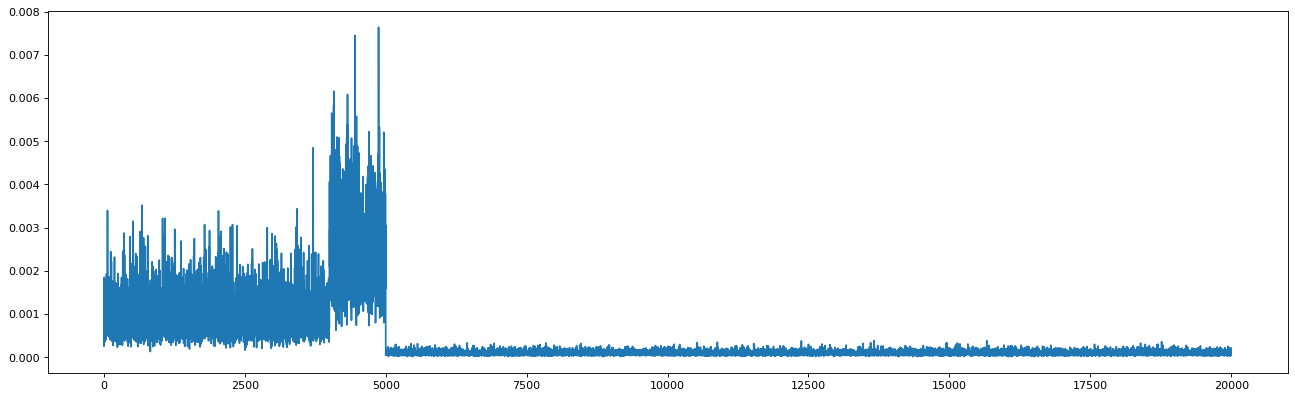

In [288]:
print(flattenedData4)
pyplot.clf()
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsFlatPooled4[:, 3])

tensor([[1.0318e-04, 7.1909e-04, 2.1672e-04, 7.1909e-04],
        [1.2506e-04, 1.1996e-03, 1.1220e-04, 1.1996e-03],
        [5.9096e-05, 5.4921e-04, 4.7854e-05, 5.4921e-04],
        ...,
        [9.5681e-05, 2.9140e-05, 8.1306e-05, 1.7900e-04],
        [1.6374e-04, 9.5763e-05, 1.5421e-04, 2.9972e-04],
        [1.3953e-04, 2.3317e-04, 1.2681e-04, 1.7601e-04]])


<Figure size 432x288 with 0 Axes>

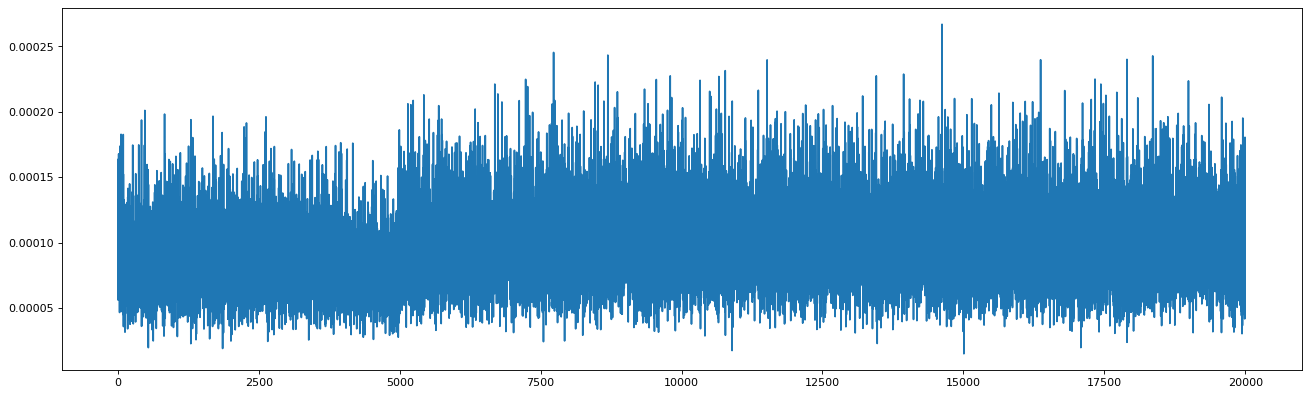

In [282]:
print(flattenedData3)
pyplot.clf()
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsFlatPooled3[:, 0])

In [281]:
print("corr for 4", np.corrcoef(afsFlatPooled4[4000:5000, 1], afsFlatPooled4[4000:5000, 3]))
print("corr for 3", np.corrcoef(afsFlatPooled4[0:2000, 0], afsFlatPooled4[0:2000, 1]))

from pyro.distributions import Multinomial

torch.exp(Multinomial(probs=tensor([0.8726, 0.0875, 0.0366, 0.0032])).log_prob(altCountsFlatPooled4[0:2000]))


corr for 4 [[1.         0.91623826]
 [0.91623826 1.        ]]
corr for 3 [[1.        0.5442306]
 [0.5442306 1.       ]]


tensor([1.2312e-05, 3.3971e-03, 9.2439e-06,  ..., 2.2688e-04, 7.2949e-08,
        2.1034e-03])

tensor([[8.6933e-05, 7.6084e-04, 8.4495e-05, 7.6084e-04],
        [5.3346e-05, 4.7881e-04, 1.0357e-04, 4.7881e-04],
        [8.0309e-05, 1.2285e-03, 8.6144e-05, 1.2285e-03],
        ...,
        [9.7155e-05, 1.1197e-04, 1.4983e-04, 6.8495e-05],
        [1.1968e-04, 9.2315e-05, 1.5075e-04, 1.9200e-04],
        [1.4755e-04, 1.5299e-04, 1.6652e-04, 1.6753e-04]])


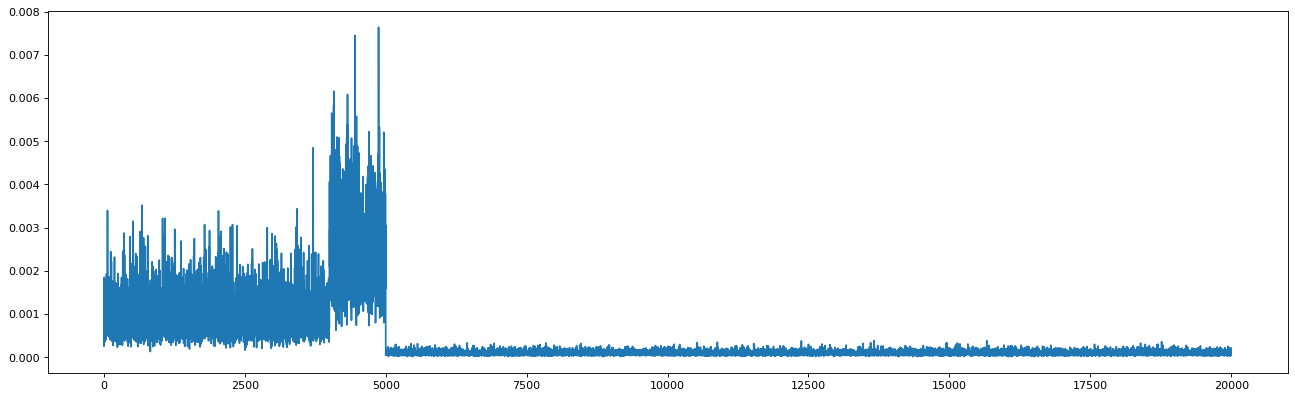

In [333]:
print(flattenedData2)

f = pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsFlatPooled4[:, 3])
pyplot.show()
f.savefig("case12.png", bbox_inches='tight')

In [51]:
print(afsFlatPooled2[0:5000, 3].mean())
afsFlatPooled2[5000:, 3].mean()

tensor(0.0015)


tensor(4.6793e-05)

In [56]:
print("empirical rr for both", afsFlatPooled2[0:5000, 3].mean()/ afsFlatPooled2[5000:, 3].mean())
print("empirical rr for 1", ((afsFlatPooled2[0:2000, 1].mean()))/ afsFlatPooled2[2000:4000, 1].mean())
print("empirical rr for 2", ((afsFlatPooled2[2000:4000, 2].mean() + afsFlatPooled2[4000:5000, 2].mean())/2)/ afsFlatPooled2[:2000, 2].mean())
# print("nullLikelihoodGlobal 1", (nullLikelihoodsGlobal[0:2000, 0] + nullLikelihoodsGlobal[4000:5000, 0]).mean(), nullLikelihoodsGlobal[2000:, 0].mean())
# print("nullLikelihoodGlobal 2", nullLikelihoodsGlobal[2000:4000, 1].mean(), nullLikelihoodsGlobal[4000:, 1].mean())
# print("nullLikelihoodGlobal Both", nullLikelihoodsGlobal[4000:5000, 2].mean(), nullLikelihoodsGlobal[0:4000, 2].mean())

empirical rr for both tensor(31.0443)
empirical rr for 1 tensor(31.3405)
empirical rr for 2 tensor(31.2599)


In [128]:
# print("empirical rr for both", afsFlatPooled2[0:5000, 3].mean()/ afsFlatPooled2[5000:, 3].mean())
print("empirical rr for 1", ((afsByGenePooledCtrls2b[0:2000, 0, 1].median()))/ afsByGenePooledCtrls2b[2000:4000, 0, 1].median())
# print("empirical rr for 2", ((afsFlatPooled2[2000:4000, 2].mean() + afsFlatPooled2[4000:5000, 2].mean())/2)/ afsFlatPooled2[:2000, 2].mean())
# print("nullLikelihoodGlobal 1", (nullLikelihoodsGlobal[0:2000, 0] + nullLikelihoodsGlobal[4000:5000, 0]).mean(), nullLikelihoodsGlobal[2000:, 0].mean())
# print("nullLikelihoodGlobal 2", nullLikelihoodsGlobal[2000:4000, 1].mean(), nullLikelihoodsGlobal[4000:, 1].mean())
# print("nullLikelihoodGlobal Both", nullLikelihoodsGlobal[4000:5000, 2].mean(), nullLikelihoodsGlobal[0:4000, 2].mean())

empirical rr for 1 tensor(9.7699)


In [115]:
len(afsByGenePooledCtrls[2000:4000, 0, 1].nonzero())

2000

In [ ]:
altCountsByGenePooledCtrls[:, :, :].sum([1,2])

In [ ]:
altCountsByGenePooledCtrls[:, :, :]

In [ ]:
randomDist = Uniform(0, 1)
randomDist2 = Uniform(1, 10000)
fnArgs = []
# pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
# P(V|D) * P(D) / P(V)
nGenes = len(altCountsByGenePooledCtrls)

probs = randomDist.sample([3,])
probs = probs / probs.sum()
print(probs)
    #pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth
fnArgs = [*probs, *randomDist2.sample([4,])]
fnArgs

In [ ]:
llPooledBivariateSingleGene(tensor([10.,1.,1.,20000.]), tensor([.01,.01,.05]), tensor(13.), tensor(10.), tensor(10.), tensor(100000.), tensor(.77), tensor(.1), tensor(.1), tensor(.01))

In [ ]:
#this gives -2.401 log(likelihoodUnivariateSingleGene(xCtrl = 10, xCase1 = 1, prevalence1 = .01, pi0 = .9, pi1 = .1, pDiseaseGivenVariant = .001))
#tensor(-2.5290): llUnivariateSingleGeneJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
r = llUnivariateSingleGeneNoJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
assert(abs(-r + tensor(-2.4010)) < .1)

In [ ]:
altCounts = tensor([10., 2., 3., 1.])
n = altCounts.sum()

testAlpha = tensor([16., 20., 30., 15.])
print(f"test data: testAlpha: {testAlpha}, n: {n}, altCounts: {altCounts}")
DirichletMultinomial(total_count=n, concentration=testAlpha).log_prob(altCounts)

In [ ]:
pDgivenV(.01, afsByGene[0:2000, 0, 1], 1e-4).mean()

In [ ]:
### Test functions
pDgivenV(.01, afsByGeneRR2[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).mean()

In [ ]:
# variance is wrong
def betaVariance(alpha, beta):
    return (alpha * beta) / ( ((alpha + beta)**2) + (alpha + beta + 1) )

def betaMean(alpha, beta):
    return alpha / (alpha + beta)

print("variance", betaVariance(6.47e1,5.39e3))
print("mean", betaMean(6.47e1,5.39e3))
print("true varianc", )

In [ ]:
m1 = afsByGene[0:2000, 0, 1].mean()
m2 = afsByGeneRR2[0:2000, 0, 1].mean()/afsByGeneRR2[2000:, 0, 1].mean()
m1 - m2
print(m1, m2)

In [ ]:
start = time.time()
res = fitFnUniveriate(altCountsByGene, pDs, nEpochs=20, minLLThresholdCount=20, debug=True)
print((time.time() - start) / 20, "per iteration")
res

In [ ]:
fitFnUniveriate(altCountsByGeneRR2, pDs)

In [ ]:
pDgivenV(pDs[0], afsByGeneRR2Shape5[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).std()

In [ ]:
pDgivenV?

In [ ]:
fitFnUniveriate(altCountsByGeneRR2, pDs, debug=True)

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2, pDs, debug=True)

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, debug=True)

In [ ]:
Beta(2.23307950e+02, 2.52700651e+04).sample([10_000,]).mean()

In [ ]:
Beta(2.20865706e+02, 1.73544747e+04).sample([10_000,]).std()

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR3, pDs, nEpochs=50)

In [ ]:
Beta(2.50432693e+02, 1.87756988e+04).sample([10_000]).mean()

In [ ]:
fitFnUniveriate(altCountsByGeneRR3, pDs, nEpochs=50)

In [ ]:
Beta(3.84376856e+02, 2.37879954e+04).sample([10_000]).mean()

In [ ]:
resultsRR2Shape5 = []
for i in range(1):
    res = fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, nEpochs=50, minLLThresholdCount=50, debug=False)
    resultsRR2Shape5.append(res)

In [ ]:
resultsRR2Shape5

In [ ]:
Beta(1.96912591e+02, 1.61461738e+04).sample([10000,]).mean()

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=50, minLLThresholdCount=50, debug=False)

In [ ]:
Beta(3.30289057e+03, 2.94460355e+04).sample([10000,]).mean()

In [ ]:
# doesn't really work resConstrained = fitFnUniveriateBetaBinomialConstrained(altCountsByGeneRR2Shape5, pDs, nEpochs=10, minLLThresholdCount=10, debug=True)
#resConstrained

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=10, minLLThresholdCount=10, debug=False)

In [ ]:
cachedData

In [70]:
params = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": []}
cachedData = [[altCountsByGenePooledCtrls, afsByGenePooledCtrls, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean
        }]]

In [145]:
params2 = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": [], "costFnIdx": []}
cachedData2 = [[altCountsByGenePooledCtrls2, afsByGenePooledCtrls2, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean,
        }]]

In [ ]:
for i in range(10):
    if i >= len(cachedData):
        start = time.time()
        altCountsByGenePooledCtrls, afsByGenePooledCtrls = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
        print("took", time.time() - start)
        cachedData.append([altCountsByGenePooledCtrls, afsByGenePooledCtrls, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean
        }])
        
    res = fitFnBivariate(cachedData[i][0], pDsGlobalLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=0)
    bestRes = res["params"][-1]

    inferredPis = tensor(bestRes[0:3])
    print("inferredPis", inferredPis)
    inferredAlphas = tensor(bestRes[3:])
    print("inferredAlphas", inferredAlphas)
    
    inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

    params["lls"].append(res["lls"][-1])
    params["inferredAlphas"].append(inferredAlphas)
    params["inferredPis"].append(inferredPis)
    params["inferredPDVs"].append(inferredPDs)

    truth1 = pDgivenV(pDsGlobalLarge[0], afsByGenePooledCtrls[0:2000, 0, 1], afsByGenePooledCtrls[0:2000, 0, 0]).mean()
    truth2 = pDgivenV(pDsGlobalLarge[1], afsByGenePooledCtrls[2000:4000, 1, 1], afsByGenePooledCtrls[2000:4000, 0, 0]).mean()
    truth3 = pDgivenV(pDsGlobalLarge[2], afsByGenePooledCtrls[4000:5000, 2, 1], afsByGenePooledCtrls[4000:5000, 0, 0]).mean()
    truth0 = 1 - (truth1 + truth2 + truth3)
    print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

    params["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
    params["truePis"].append(tensor(diseaseFractions))

    print(f"params on run {i}", params)

In [ ]:
for i in range(10):
    if i >= len(cachedData2):
        start = time.time()
        altCountsByGenePooledCtrls2, afsByGenePooledCtrls2 = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
        print("took", time.time() - start)
        cachedData2.append([altCountsByGenePooledCtrls2, afsByGenePooledCtrls2, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean,
        }])
    runCostFnIdx = 6
    # todo append all entries to indciate failure
    params2["costFnIdx"].append(runCostFnIdx)

    res = fitFnBivariate(cachedData2[i][0], pDsGlobalLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
    
    
    bestRes = res["params"][-1]

    inferredPis = tensor(bestRes[0:3])
    print("inferredPis", inferredPis)
    inferredAlphas = tensor(bestRes[3:])
    print("inferredAlphas", inferredAlphas)
    
    inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

    params2["lls"].append(res["lls"][-1])
    params2["inferredAlphas"].append(inferredAlphas)
    params2["inferredPis"].append(inferredPis)
    params2["inferredPDVs"].append(inferredPDs)

    truth1 = pDgivenV(pDsGlobalLarge[0], cachedData2[i][1][0:2000, 0, 1], cachedData2[i][1][0:2000, 0, 0]).mean()
    truth2 = pDgivenV(pDsGlobalLarge[1], cachedData2[i][1][2000:4000, 1, 1], cachedData2[i][1][2000:4000, 0, 0]).mean()
    truth3 = pDgivenV(pDsGlobalLarge[2], cachedData2[i][1][4000:5000, 2, 1], cachedData2[i][1][4000:5000, 0, 0]).mean()
    truth0 = 1 - (truth1 + truth2 + truth3)
    print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

    params2["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
    params2["truePis"].append(tensor(diseaseFractions))
    
    print(f"params on run {i}", params2)

In [244]:
params3 = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": [], "costFnIdx": []}
cachedData3 = [[altCountsByGenePooledCtrls3, afsByGenePooledCtrls3, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean,
        }]]

In [ ]:
for i in range(2):
    if i >= len(cachedData3):
        start = time.time()
        altCountsByGenePooledCtrls3, afsByGenePooledCtrls3 = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
        print("took", time.time() - start)
        cachedData3.append([altCountsByGenePooledCtrls3, afsByGenePooledCtrls3, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean,
        }])
    runCostFnIdx = 7
    # todo append all entries to indciate failure
    params3["costFnIdx"].append(runCostFnIdx)

    res = fitFnBivariate(cachedData3[i][0], pDsGlobalLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
    
    
    bestRes = res["params"][-1]

    inferredPis = tensor(bestRes[0:3])
    print("inferredPis", inferredPis)
    inferredAlphas = tensor(bestRes[3:])
    print("inferredAlphas", inferredAlphas)
    
    inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

    params3["lls"].append(res["lls"][-1])
    params3["inferredAlphas"].append(inferredAlphas)
    params3["inferredPis"].append(inferredPis)
    params3["inferredPDVs"].append(inferredPDs)

    truth1 = pDgivenV(pDsGlobalLarge[0], cachedData3[i][1][0:2000, 0, 1], cachedData3[i][1][0:2000, 0, 0]).mean()
    truth2 = pDgivenV(pDsGlobalLarge[1], cachedData3[i][1][2000:4000, 1, 1], cachedData3[i][1][2000:4000, 0, 0]).mean()
    truth3 = pDgivenV(pDsGlobalLarge[2], cachedData3[i][1][4000:5000, 2, 1], cachedData3[i][1][4000:5000, 0, 0]).mean()
    truth0 = 1 - (truth1 + truth2 + truth3)
    print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

    params3["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
    params3["truePis"].append(tensor(diseaseFractions))
    
    print(f"params on run {i}", params3)

In [298]:
params4 = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": [], "costFnIdx": []}
cachedData4 = [[altCountsByGenePooledCtrls4, afsByGenePooledCtrls4, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean,
        }]]

In [310]:
for i in range(2):
    if i >= len(cachedData4):
        start = time.time()
        altCountsByGenePooledCtrls4, afsByGenePooledCtrls4 = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeansCovary, afMean=afMean, afShape=afShape)
        print("took", time.time() - start)
        cachedData4.append([altCountsByGenePooledCtrls4, afsByGenePooledCtrls4, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsGlobalLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeansCovary,
            "afShape": afShape,
            "afMean": afMean,
        }])
    runCostFnIdx = 11

    res = fitFnBivariate(cachedData4[i][0], pDsGlobalLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
    
    
    bestRes = res["params"][-1]

    inferredPis = tensor(bestRes[0:3])
    print("inferredPis", inferredPis)
    inferredAlphas = tensor(bestRes[3:])
    print("inferredAlphas", inferredAlphas)
    
    inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

    params4["lls"].append(res["lls"][-1])
    params4["inferredAlphas"].append(inferredAlphas)
    params4["inferredPis"].append(inferredPis)
    params4["inferredPDVs"].append(inferredPDs)

    truth1 = pDgivenV(pDsGlobalLarge[0], cachedData4[i][1][0:2000, 0, 1], cachedData4[i][1][0:2000, 0, 0]).mean()
    truth2 = pDgivenV(pDsGlobalLarge[1], cachedData4[i][1][2000:4000, 1, 1], cachedData4[i][1][2000:4000, 0, 0]).mean()
    truth3 = pDgivenV(pDsGlobalLarge[2], cachedData4[i][1][4000:5000, 2, 1], cachedData4[i][1][4000:5000, 0, 0]).mean()
    truth0 = 1 - (truth1 + truth2 + truth3)
    print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

    params4["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
    params4["truePis"].append(tensor(diseaseFractions))
    
     # todo append all entries to indciate failure
    params4["costFnIdx"].append(runCostFnIdx)

    
    print(f"params on run {i}", params4)

altCountsFlat tensor([[39.,  9.,  1.,  0.],
        [63.,  7.,  0.,  1.],
        [24.,  0.,  0.,  0.],
        ...,
        [41.,  0.,  1.,  0.],
        [48.,  0.,  1.,  0.],
        [55.,  0.,  0.,  0.]])
n tensor([49., 71., 24.,  ..., 42., 49., 55.])
xCase1, xCase2, xCase12 tensor([9., 7., 0.,  ..., 0., 0., 0.])
xCase1, xCase2, xCase12 tensor([1., 0., 0.,  ..., 1., 1., 0.])
xCase1, xCase2, xCase12 tensor([0., 1., 0.,  ..., 0., 0., 0.])
allNull2 tensor([2.4507e-10, 7.3717e-07, 5.5288e-01,  ..., 1.4888e-01, 1.4613e-01,
        2.5715e-01])
past <function likelihoodBivariateFast.<locals>.likelihood2h at 0x7fb95da3e170>
best ll: 75189.84375, bestParams: [tensor(0.0502), tensor(0.1507), tensor(0.0471), tensor(12433.8857), tensor(1851.3630), tensor(2723.3193), tensor(19316.8867)]
epoch 0
 final_simplex: (array([[1.02153310e-01, 1.18369750e-01, 1.94489408e-04, 2.41544294e+04,
        2.27582542e+03, 1.70963181e+03, 8.40010327e+02],
       [1.02153310e-01, 1.18369750e-01, 1.94489451e-04, 2

/Users/alexkotlar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


altCountsFlat tensor([[33.,  5.,  0.,  1.],
        [30.,  6.,  0.,  1.],
        [35.,  3.,  2.,  0.],
        ...,
        [79.,  1.,  0.,  0.],
        [58.,  1.,  0.,  0.],
        [49.,  0.,  1.,  1.]])
n tensor([39., 37., 40.,  ..., 80., 59., 51.])
xCase1, xCase2, xCase12 tensor([5., 6., 3.,  ..., 1., 1., 0.])
xCase1, xCase2, xCase12 tensor([0., 0., 2.,  ..., 0., 0., 1.])
xCase1, xCase2, xCase12 tensor([1., 1., 0.,  ..., 0., 0., 1.])
allNull2 tensor([3.7364e-06, 1.4452e-07, 2.4506e-04,  ..., 1.1096e-01, 1.3745e-01,
        3.6190e-02])
past <function likelihoodBivariateFast.<locals>.likelihood2h at 0x7fb948549c20>
best ll: 73248.0859375, bestParams: [tensor(0.0466), tensor(0.0532), tensor(0.0393), tensor(22441.9531), tensor(732.0722), tensor(1926.2135), tensor(12481.6875)]
epoch 0
 final_simplex: (array([[1.05206481e-01, 5.83539633e-02, 1.36291680e-04, 1.44976455e+04,
        1.17609172e+03, 1.28181967e+03, 6.94986319e+03],
       [1.05206482e-01, 5.83539636e-02, 1.36291101e-04, 

In [216]:
np.corrcoef(afsByGenePooledCtrls4[0:2000, 0, 1], afsByGenePooledCtrls4[0:2000, 1, 1])

array([[1.        , 0.46762262],
       [0.46762262, 1.        ]])

In [304]:
def runModel(inputAltCounts, inputAfs, costFnIdx):
    params = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": []}
    cachedData = [[inputAltCounts, inputAfs, {
                "nCases": nCasesLarge,
                "nCtrls": nCtrlsLarge,
                "pDs": pDsGlobalLarge,
                "diseaseFractions": diseaseFractions,
                "rrShape": rrShape,
                "rrMeans": rrMeans,
                "afShape": afShape,
                "afMean": afMean
            }]]
    for i in range(10):
        if i >= len(cachedData2):
            start = time.time()
            altCounts, afs = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
            print("took", time.time() - start)
            cachedData2.append([altCounts, afs, {
                "nCases": nCasesLarge,
                "nCtrls": nCtrlsLarge,
                "pDs": pDsGlobalLarge,
                "diseaseFractions": diseaseFractions,
                "rrShape": rrShape,
                "rrMeans": rrMeans,
                "afShape": afShape,
                "afMean": afMean
            }])

        res = fitFnBivariate(cachedData[i][0], pDsGlobalLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=costFnIdx)
        bestRes = res["params"][-1]

        inferredPis = tensor(bestRes[0:3])
        print("inferredPis", inferredPis)
        inferredAlphas = tensor(bestRes[3:])
        print("inferredAlphas", inferredAlphas)

        inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

        params["lls"].append(res["lls"][-1])
        params["inferredAlphas"].append(inferredAlphas)
        params["inferredPis"].append(inferredPis)
        params["inferredPDVs"].append(inferredPDs)

        truth1 = pDgivenV(pDsGlobalLarge[0], cachedData[i][1][0:2000, 0, 1], cachedData[i][1][0:2000, 0, 0]).mean()
        truth2 = pDgivenV(pDsGlobalLarge[1], cachedData[i][1][2000:4000, 1, 1], cachedData[i][1][2000:4000, 0, 0]).mean()
        truth3 = pDgivenV(pDsGlobalLarge[2], cachedData[i][1][4000:5000, 2, 1], cachedData[i][1][4000:5000, 0, 0]).mean()
        truth0 = 1 - (truth1 + truth2 + truth3)
        print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

        params["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
        params["truePis"].append(tensor(diseaseFractions))

        print(f"params on run {i}", params)
        
        return params, cachedData

In [ ]:
params4, cachedData2 = runModel(altCountsByGenePooledCtrls2, afsByGenePooledCtrls2, 4)

In [ ]:
r = altCount

In [1]:
params4

NameError: name 'params4' is not defined

In [82]:
tensor([*params["inferredPis"]])

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
res = fitFnBivariate(cachedData[0][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=0)

In [ ]:
res1 = fitFnBivariate(cachedData[0][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=1)

In [ ]:
res2 = fitFnBivariate(cachedData[0][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=2)

In [ ]:
print("res0", res0)
print("\nres0", "pis", res0["params"][-1][0:3], "mean P(D|V)'s", Dirichlet(tensor(res0["params"][-1][3:])).sample([10_000]).mean(0))

print("\n\n\nres1", res1)
print("\nres1", "pis", res1["params"][-1][0:3], "mean P(D|V)'s", Dirichlet(tensor(res1["params"][-1][3:])).sample([10_000]).mean(0))

print("\n\n\nres2", res2)
print("\nres2", "pis", res2["params"][-1][0:3], "mean P(D|V)'s", Dirichlet(tensor(res2["params"][-1][3:])).sample([10_000]).mean(0))

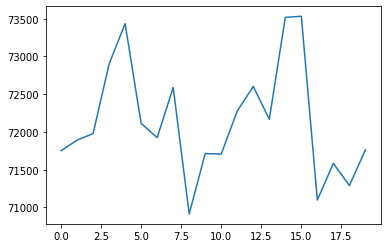

In [136]:
pyplot.plot(res0["llTrajectory"])



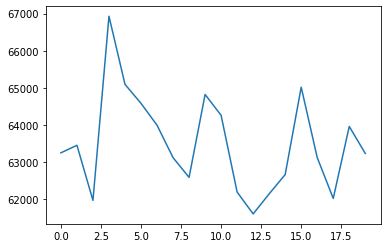

In [137]:
pyplot.plot(res1["llTrajectory"])

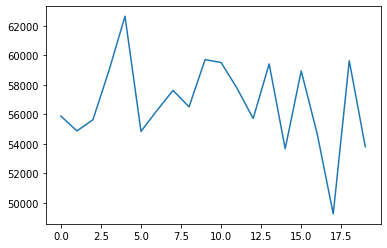

In [138]:
pyplot.plot(res2["llTrajectory"])

In [ ]:
params

In [ ]:
(afsByGenePooledCtrls[2000:4000, 1, 1]/afsByGenePooledCtrls[2000:4000, 0, 0]).mean()

In [ ]:
truth = pDgivenV(pD., afsByGenePooledCtrls[0:2000, :, 1], afsByGenePooledCtrls[0:2000, 0, 0])

In [ ]:
test = Dirichlet(tensor(1/4.0).expand(4)).sample()
test = test[0:3]
r = [0,1,2,3]
r[0:4]

In [ ]:
fitFnBivariate(altCountsByGenePooledCtrls, pDs, nEpochs=100, minLLThresholdCount=100, debug=True)

In [ ]:
d = Dirichlet(concentration=tensor([1.40625703e+04,
         5.56195520e+03, 1.57978682e+02, 2.33518936e+04]))
d.sample([10_000,]).mean(0)

In [ ]:
Beta(7.74788652e+02, 2.58170768e+04 + 9.72956833e+02 + 5.18278100e+03).sample([10000]).mean()

In [ ]:
Beta(3.05871723e+04, 3.25256694e+02 + 3.75135881e+03 +4.52942294e+04).sample([10000,]).mean()

In [ ]:
start = time.time()
res = fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=100, minLLThresholdCount=100, debug=False)
print("fitFnUniveriateBetaBinomial took for 100 epochs: ", time.time() - start)

In [ ]:
pyplot.plot(res["llTrajectory"])
res

In [ ]:
binomH0 = Binomial(total_count=tensor([1.,1]), probs=pDs[0])

In [ ]:
binomH0.log_prob(tensor(1.))

In [ ]:
costFn2 = likelihoodUnivariateFast(altCountsByGene, pDs)
# print(costFn2([1e-9, .999999]))
print(costFn2([1e-9, 1e-9]))
print(costFn2([0.08845797,0.11094360])) #gives ~12067 using jensen's method, and ~9887 using exponentiation of the log

# best result from R
#  0.08845797           0.11094360 , ll -10127.23, and with jensen's version, "example -12037.4347455843"
# pDgivenV, pi1


In [ ]:
costFn = likelihoodUnivariate(altCountsByGene, pDs)
print("costFn1:", costFn([.001, .01]),"costFn2:",costFn2([.001, .01]))

In [ ]:
costFn([0.0001,0.11094360])

In [ ]:
print(costFn2([0.0001,0.11094360]))

In [ ]:
d = Binomial(total_count=tensor([14., 0., 9.]), probs=tensor(.0099))
d.log_prob(tensor([0.,0.,0.]))

In [ ]:
costFn2([1e-9, .999999])

In [ ]:
binomH0 = Binomial(total_count=geneSums, probs=.001)
binomH1 = Binomial(total_count=geneSums, probs=.01)
caseAltCounts = altCountsByGene[:, 0, 1]
print(caseAltCounts)
component0 = binomH0.log_prob(caseAltCounts)
print("component0", component0, .5*component0)
component1 = binomH1.log_prob(caseAltCounts)

In [ ]:
pDgivenV(pDs[0], afsByGene2[0:2000, 0, 1].mean(), afMean)

In [ ]:
condition1 = altCountsByGene2[:, 0, :]
condition1
pDs[0]

afsByGene2[0:2000,:,1].mean()

In [ ]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGene2[:, 0, 1:2].flatten())
pyplot.plot(afsByGene2[:, 0, 0:1].flatten())

In [ ]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGenePooledCtrls[:, 0, 0:1].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 0, 1:2].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 1, 1:2].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 2, 1:2].flatten())
# pyplot.plot(afsByGeneRR2[:, 0, 1:2].flatten())
# pyplot.plot(afsByGeneRR2[:, 0, 0:1].flatten())

In [ ]:
ctrlCounts = altCountsByGene[:, 0, 0]
altCountsCases = altCountsByGene[:, :, 1]

altCountsFlat = []
for geneIdx in range(nGenes):
    altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1].flatten()])
altCountsFlat = tensor(altCountsFlat)

In [ ]:
altCountsFlat[0]

In [ ]:
DirichletMultinomial?

In [ ]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)

K = 4  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    alpha0 = pyro.sample('alpha0', Uniform(1, 2.5e4))
    alpha1 = pyro.sample('alpha0', Uniform(1, 2.5e4))
    alpha2 = pyro.sample('alpha0', Uniform(1, 2.5e4))
    alpha3 = pyro.sample('alpha0', Uniform(1, 2.5e4))

    with pyro.plate('components', K):
        concentrations = pyro.sample('concentrations', dist.Dirichlet(0.5 * torch.ones(K)))

    with pyro.plate('data', len(data)):
        # Local variables.
        component = pyro.sample('assignment', dist.Categorical(weights))
        print(f"concentrations: {concentrations[component]}")
        pyro.sample('obs', DirichletMultinomial(concentration=concentrations[component], total_count=data.sum(1)), obs=data)

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "concentrations":
        return torch.ones(K) / K
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentrations']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, altCountsFlat)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(2))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

In [ ]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(altCountsFlat)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

In [148]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

NameError: name 'losses' is not defined

<Figure size 1000x300 with 0 Axes>

In [ ]:
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
map_estimates = global_guide(altCountsFlat)
weights = map_estimates['weights']
locs = map_estimates['concentrations']
print('weights = {}'.format(weights.data.numpy()))
print('concentrations = {}'.format(locs.data.numpy()))

In [ ]:
Dirichlet(tensor([0.8973397  , 0.0494441,  0.04917945, 0.00403667])).sample([10_000,]).mean()